In [1]:
CSV_PATH = "/home/zhimin90/CPT/CSVs/"

from datetime import timedelta, date
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np

from sodapy import Socrata

import dill
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from KDEpy import FFTKDE, NaiveKDE

client = Socrata("data.cityofchicago.org", None)
results = client.get("wqdh-9gek",order="request_date DESC", limit=100000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)


In [2]:
test_df = results_df
test_df.columns = pd.Series(test_df.columns).apply(lambda x: x.upper()).values
xbound = (-87.9361,-87.5245)
ybound = (41.6447,42.023)
test_df = test_df[test_df.LATITUDE.notna()].sort_values(['REQUEST_DATE','COMPLETION_DATE'], ascending=[0,0])
test_df['REQUEST_DATE'] = pd.to_datetime(test_df['REQUEST_DATE'])
test_df['COMPLETION_DATE'] = pd.to_datetime(test_df['COMPLETION_DATE'])
test_df['LATITUDE'] = pd.to_numeric(test_df['LATITUDE'])
test_df['LONGITUDE'] = pd.to_numeric(test_df['LONGITUDE'])
df = test_df

In [3]:
map_arr = []
interval_int = 30 #use 30 days data to predict next 7 days
series_range = 7 #days
time_interval = timedelta(days=interval_int)
date_start = min(df['REQUEST_DATE'])
date_end = max(df['REQUEST_DATE'])

geo_price_map = df[['REQUEST_DATE', 'COMPLETION_DATE','LATITUDE', 'LONGITUDE']]

In [4]:
filter1a = pd.to_numeric(geo_price_map["LONGITUDE"]) > xbound[0]
filter1b = pd.to_numeric(geo_price_map["LONGITUDE"]) < xbound[1]
filter1c = pd.to_numeric(geo_price_map["LATITUDE"]) > ybound[0]
filter1d = pd.to_numeric(geo_price_map["LATITUDE"]) < ybound[1]
print("sum of remaining is: " + str(sum(filter1a&filter1b&filter1c&filter1d)))
geo_price_map = geo_price_map[filter1a&filter1b&filter1c&filter1d]

sum of remaining is: 52640


In [5]:
for int_cur_date in range(0, (date_end - date_start).days - interval_int, int(series_range)):
    geo_price_map_filtered = geo_price_map[geo_price_map['LONGITUDE'].notnull()]
    
    filter2 = geo_price_map_filtered['REQUEST_DATE'] > (date_end - timedelta(days=int_cur_date+interval_int))
    filter3 = geo_price_map_filtered['REQUEST_DATE'] <= (date_end -  timedelta(days=int_cur_date))
    
    print(date_end - timedelta(days=int_cur_date+interval_int))
    print(date_end -  timedelta(days=int_cur_date))
    
    geo_price_map_filtered = geo_price_map_filtered.where(filter2 & filter3)
    print("pothole count: " + str(len(geo_price_map_filtered.notnull().index)))
    print("_"*20)
    map_arr.append(geo_price_map_filtered)

2020-02-19 14:02:01
2020-03-20 14:02:01
pothole count: 52640
____________________
2020-02-12 14:02:01
2020-03-13 14:02:01
pothole count: 52640
____________________
2020-02-05 14:02:01
2020-03-06 14:02:01
pothole count: 52640
____________________
2020-01-29 14:02:01
2020-02-28 14:02:01
pothole count: 52640
____________________
2020-01-22 14:02:01
2020-02-21 14:02:01
pothole count: 52640
____________________
2020-01-15 14:02:01
2020-02-14 14:02:01
pothole count: 52640
____________________
2020-01-08 14:02:01
2020-02-07 14:02:01
pothole count: 52640
____________________
2020-01-01 14:02:01
2020-01-31 14:02:01
pothole count: 52640
____________________
2019-12-25 14:02:01
2020-01-24 14:02:01
pothole count: 52640
____________________
2019-12-18 14:02:01
2020-01-17 14:02:01
pothole count: 52640
____________________
2019-12-11 14:02:01
2020-01-10 14:02:01
pothole count: 52640
____________________
2019-12-04 14:02:01
2020-01-03 14:02:01
pothole count: 52640
____________________
2019-11-27 14:02

2018-02-28 14:02:01
2018-03-30 14:02:01
pothole count: 52640
____________________
2018-02-21 14:02:01
2018-03-23 14:02:01
pothole count: 52640
____________________
2018-02-14 14:02:01
2018-03-16 14:02:01
pothole count: 52640
____________________
2018-02-07 14:02:01
2018-03-09 14:02:01
pothole count: 52640
____________________


In [6]:
map_arr.reverse()
pothole_count = []
for df in map_arr:
    pothole_count.append(df.count())

In [7]:



def get_kde( x, y, xmin, xmax, ymin, ymax, xx, yy, positions):

    values = np.array([x, y]).T
    #values = values.reshape(values.shape[1], values.shape[0])
    #print("values is: " + str(values))
    #grid, points = get_kernel(values)
    points = get_kernel(values, positions)
    #kernel.set_bandwidth(bw_method=kernel.factor / 30.)
    f = np.reshape(points, xx.shape)
    #print(points.shape)
    #print(grid)
    #return grid, f
    return f

def get_kernel(data, positions):
    #print(data.shape)
    #print(data)
    estimator = FFTKDE(kernel='gaussian', norm=2, bw=0.001)
    #grid, points = estimator.fit(data, weights=None).evaluate(grid_size)
    points = estimator.fit(data, weights=None).evaluate(positions)
    #grid, points = estimator.fit(data, weights=None).evaluate(grid_size)
    #kernel = gaussian_kde(dataset=values, bw_method="silverman" )
    #return grid, points
    return points

In [8]:
grid_size = 1000
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

xx, yy = np.mgrid[xmin:xmax:(grid_size*1j), ymin:ymax:(grid_size*1j)]
positions = np.dstack([xx.ravel(), yy.ravel()])
positions = positions.reshape(positions.shape[1], positions.shape[2])
grid_matrix = positions

In [9]:
for i, df in enumerate(map_arr):
    if df["LONGITUDE"].count() > 400:
        #grid, points = get_kde(df["LONGITUDE"].dropna().to_numpy(), df["LATITUDE"].dropna().to_numpy() , xmin, xmax, ymin, ymax, xx, yy, positions)
        points = get_kde(df["LONGITUDE"].dropna().to_numpy(), df["LATITUDE"].dropna().to_numpy() , xmin, xmax, ymin, ymax, xx, yy, positions)
        density_matrix_t_series.append(points)
        print("@" + str(i))

@22
@26
@27
@28
@29
@30
@31
@32
@33
@34
@35
@36
@37
@38
@39
@40
@41
@42
@43
@44
@45
@46
@47
@48
@49
@50
@51
@52
@53
@54
@55
@56
@57
@58
@59
@60
@61
@62
@63
@64
@65
@66
@67
@68
@69
@70
@71
@72
@73
@74
@75
@76
@77
@78
@79
@80
@81
@82
@83
@84
@85
@86
@87
@88
@89
@90
@91
@92
@93
@94
@95
@96
@97
@98
@99
@100
@101
@102
@103
@104
@105
@106


In [10]:
s = round(len(density_matrix_t_series)*0)

In [33]:


f_in = open(CSV_PATH +'Scalers_2020.pkl', "rb")
scaler,scaler2 = dill.load(f_in)
f_in.close()

dm_series_np = np.array(density_matrix_t_series[s:])
flattened_matrix_np = np.reshape(dm_series_np, (dm_series_np.shape[0]*dm_series_np.shape[1], dm_series_np.shape[2]))

normalized_matrices_test = scaler2.transform(scaler.transform(flattened_matrix_np))
x_test = normalized_matrices_test[0:-normalized_matrices_test.shape[1]].copy()
y_test = normalized_matrices_test[normalized_matrices_test.shape[1]-1:-1].copy()

x_test2 = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
y_test2 = y_test 

In [34]:
import tensorflow.keras as keras
model = keras.models.load_model(CSV_PATH + 'TensorFlowModel_2020_train_save')

In [35]:
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta

def predictor(model, data_in, grid, start_frame_date, end_frame_date, time_shift):
    xx, yy = grid
    offset = yy.shape[0]
    print("offset = yy.shape[0]" + str(offset))
    xx = xx.ravel()
    yy = yy.ravel()
    xdelta = abs(xx[1] - xx[1+offset])
    ydelta = abs(yy[0] - yy[1+offset])
    print("xdelta"+str(xdelta))
    print("ydelta"+str(ydelta))
    columns = [ 'start_date', 'end_date', 'poly_coordinate', 'density']
    
    pred = model.predict(data_in)
    data = scaler.inverse_transform(scaler2.inverse_transform(pred))
    data_reshaped = data.reshape((int(data.shape[0]/data.shape[1]), data.shape[1], data.shape[1]))
    print(data_reshaped.shape)
    #each cell is a density estimate from KDE that that has been aggregated by number of potholes over time
    #This time interval of density cell is input frame time + timeshift the target frame in the model that has shifted forward by
    
    row_dict = {'start_date' : None, 'end_date' : None, 'poly_coordinate': None, 'density': 0}
    #append = pd.DataFrame(columns=columns)
    dict_list = []
    for t, matrix in enumerate(data_reshaped):
        xy_matrix = np.flip(np.rot90(matrix),0)
        print(xy_matrix.shape)
        row_dict['start_date'] = pd.to_datetime(start_frame_date) + timedelta(days=(time_shift*(t+1)))
        row_dict['end_date'] = pd.to_datetime(end_frame_date) + timedelta(days=(time_shift*(t+1)))
        
        for i, row in enumerate(xy_matrix):
            for j, cell in enumerate(row):
                pos_index = i + j*xy_matrix.shape[1]
                #generate density cell (square) polycoordinate [[cxmin,cymin],[cxmax, cymin],[cxmin, cymax],[cxmax, cymax]]
                row_dict['poly_coordinate'] = [[xx[pos_index],yy[pos_index]],[xx[pos_index]+xdelta,yy[pos_index]],[xx[pos_index]+xdelta,yy[pos_index]+ydelta], [xx[pos_index],yy[pos_index]+ydelta]]
                row_dict['density'] = cell
                dict_list.append(row_dict.copy())

    return pd.DataFrame(dict_list)

In [36]:
Last_time_frame = y_test2[-(y_test2.shape[1]+1):-1]
start_frame_date = min(map_arr[-1]['REQUEST_DATE'][map_arr[-1]['REQUEST_DATE'].notna()])
end_frame_date = max(map_arr[-1]['REQUEST_DATE'][map_arr[-1]['REQUEST_DATE'].notna()])
time_shift = 7 #days
dataframe = predictor(model,np.reshape(Last_time_frame,(Last_time_frame.shape[0],1,Last_time_frame.shape[1])), (xx, yy), start_frame_date, end_frame_date, time_shift)

offset = yy.shape[0]1000
xdelta0.0004944144144189977
ydelta0.0004544144144134066
(1, 1000, 1000)
(1000, 1000)


In [37]:
import geopandas as gpd
from shapely.geometry import Polygon

In [38]:
df = dataframe
df["int_density"] = df.density.astype(int)

In [39]:
list = []
for index, row in df.iterrows():
    list.append( [row['start_date'],  row['end_date'],Polygon( row['poly_coordinate']), row['density'], row['int_density']] )

In [40]:
gdf = gpd.GeoDataFrame(list, columns =['start_date','end_date', 'geometry', 'density', 'int_density'])
xmin, ymin, xmax, ymax = gdf.total_bounds

In [75]:
grid_size = 10
xgrid = np.arange(xmin, xmax, (xmax-xmin)/grid_size)
ygrid = np.arange(ymin, ymax, (ymax-ymin)/grid_size)
print(xgrid,ygrid)

[-87.97726    -87.92781856 -87.87837712 -87.82893568 -87.77949423
 -87.73005279 -87.68061135 -87.63116991 -87.58172847 -87.53228703] [41.60687    41.65231144 41.69775288 41.74319432 41.78863577 41.83407721
 41.87951865 41.92496009 41.97040153 42.01584297]


In [76]:
c = 0
gdf["zone"] = None
for row in xgrid:
    for col in ygrid:
        boundbox = Polygon([[row,col],[row+(xmax-xmin)/grid_size,col],[row+(xmax-xmin)/grid_size,col+(ymax-ymin)/grid_size],[row,col+(ymax-ymin)/grid_size],[row,col]])
        bb_df = gpd.GeoSeries(boundbox)
        bool_within_bb = gdf.geometry.intersects(boundbox)
        index_within_bb = gdf[bool_within_bb].index
        gdf.iloc[index_within_bb,5] = c
        c+=1
        print(c)
        print("count rows within count: " + str(len(index_within_bb)))
        print("-"*25)

1
count rows within count: 10201
-------------------------
2
count rows within count: 10302
-------------------------
3
count rows within count: 10201
-------------------------
4
count rows within count: 10201
-------------------------
5
count rows within count: 10201
-------------------------
6
count rows within count: 10201
-------------------------
7
count rows within count: 10201
-------------------------
8
count rows within count: 10201
-------------------------
9
count rows within count: 10201
-------------------------
10
count rows within count: 10201
-------------------------
11
count rows within count: 10302
-------------------------
12
count rows within count: 10404
-------------------------
13
count rows within count: 10302
-------------------------
14
count rows within count: 10302
-------------------------
15
count rows within count: 10302
-------------------------
16
count rows within count: 10302
-------------------------
17
count rows within count: 10302
---------------

In [77]:
gdf[gdf["zone"].isnull()]

,start_date,end_date,geometry,density,int_density,zone


In [78]:
gdf_dissolved = gdf.dissolve(by=['int_density','zone'])

In [79]:
gdf_dissolved

geometry  \
int_density zone                                                      
-11         52    POLYGON ((-87.68457 41.73910, -87.68407 41.739...   
-10         52    POLYGON ((-87.68407 41.73910, -87.68358 41.739...   
-9          52    MULTIPOLYGON (((-87.72313 41.70457, -87.72363 ...   
-8          52    MULTIPOLYGON (((-87.68704 41.71229, -87.68704 ...   
            56    MULTIPOLYGON (((-87.72412 41.88497, -87.72461 ...   
...                                                             ...   
 231        53    POLYGON ((-87.72363 41.74728, -87.72313 41.747...   
 235        53    POLYGON ((-87.72264 41.74592, -87.72214 41.745...   
 240        53    POLYGON ((-87.72363 41.74592, -87.72313 41.745...   
 247        53    POLYGON ((-87.72214 41.74683, -87.72214 41.746...   
 252        53    POLYGON ((-87.72313 41.74683, -87.72313 41.746...   

                          start_date            end_date     density  
int_density zone                                                      
-11         52   2020-02-26 14:08:21 2020-03-27 14:02:01  -11.184847  
-10         52   2020-02-26 14:08:21 2020-03-27 14:02:01  -10.431181  
-9          52   2020-02-26 14:08:21 2020-03-27 14:02:01   -9.416748  
-8          52   2020-02-26 14:08:21 2020-03-27 14:02:01   -8.372173  
            56   2020-02-26 14:08:21 2020-03-27 14:02:01   -8.075526  
...                              ...                 ...         ...  
 231        53   2020-02-26 14:08:21 2020-03-27 14:02:01  231.428574  
 235        53   2020-02-26 14:08:21 2020-03-27 14:02:01  235.034103  
 240        53   2020-02-26 14:08:21 2020-03-27 14:02:01  240.485931  
 247        53   2020-02-26 14:08:21 2020-03-27 14:02:01  247.902939  
 252        53   2020-02-26 14:08:21 2020-03-27 14:02:01  252.756195  

[1712 rows x 4 columns]

In [80]:
max(gdf_dissolved["density"])

252.75619506835938

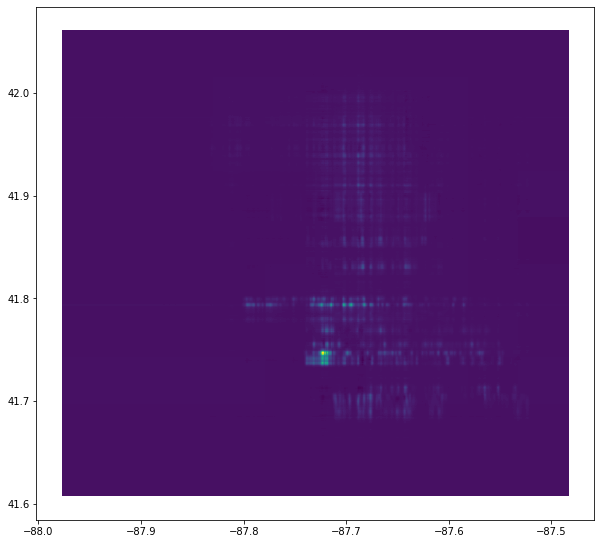

In [81]:
gdf_dissolved[["geometry","density"]].plot(column='density',figsize=(10,10))

In [83]:
gdf_dissolved.iloc[:2,]

,,geometry,start_date,end_date,density
int_density,zone,,,,
-11,52,"POLYGON ((-87.68457 41.73910, -87.68407 41.739...",2020-02-26 14:08:21,2020-03-27 14:02:01,-11.184847
-10,52,"POLYGON ((-87.68407 41.73910, -87.68358 41.739...",2020-02-26 14:08:21,2020-03-27 14:02:01,-10.431181


In [88]:
def applyInsert(geometry,start_d,end_d,density):
    print(geometry,start_d,end_d,density)
    print("-"*100)
        
gdf_dissolved.iloc[:5,:].apply(lambda row: applyInsert(row.geometry, row.start_date, row.end_date, row.density), axis=1)

POLYGON ((-87.68456666666667 41.73910459459459, -87.68407225225225 41.73910459459459, -87.68407225225225 41.73955900900901, -87.68456666666667 41.73955900900901, -87.68456666666667 41.73910459459459)) 2020-02-26 14:08:21 2020-03-27 14:02:01 -11.184846878051758
----------------------------------------------------------------------------------------------------
POLYGON ((-87.68407225225225 41.73910459459459, -87.68357783783783 41.73910459459459, -87.68357783783783 41.73955900900901, -87.68407225225225 41.73955900900901, -87.68407225225225 41.73910459459459)) 2020-02-26 14:08:21 2020-03-27 14:02:01 -10.431180953979492
----------------------------------------------------------------------------------------------------
MULTIPOLYGON (((-87.723130990991 41.7045690990991, -87.7236254054054 41.7045690990991, -87.7236254054054 41.70502351351352, -87.723130990991 41.70502351351352, -87.72313099099098 41.70502351351352, -87.72263657657658 41.70502351351352, -87.72214216216216 41.70502351351352, -8

int_density  zone
-11          52      None
-10          52      None
-9           52      None
-8           52      None
             56      None
dtype: object

In [89]:
gdf_dissolved.iloc[:5,:]

geometry  \
int_density zone                                                      
-11         52    POLYGON ((-87.68457 41.73910, -87.68407 41.739...   
-10         52    POLYGON ((-87.68407 41.73910, -87.68358 41.739...   
-9          52    MULTIPOLYGON (((-87.72313 41.70457, -87.72363 ...   
-8          52    MULTIPOLYGON (((-87.68704 41.71229, -87.68704 ...   
            56    MULTIPOLYGON (((-87.72412 41.88497, -87.72461 ...   

                          start_date            end_date    density  
int_density zone                                                     
-11         52   2020-02-26 14:08:21 2020-03-27 14:02:01 -11.184847  
-10         52   2020-02-26 14:08:21 2020-03-27 14:02:01 -10.431181  
-9          52   2020-02-26 14:08:21 2020-03-27 14:02:01  -9.416748  
-8          52   2020-02-26 14:08:21 2020-03-27 14:02:01  -8.372173  
            56   2020-02-26 14:08:21 2020-03-27 14:02:01  -8.075526